04. PyTorch Custom Datasets Video Notebook

In [1]:
import torch 
from torch import nn

torch.__version__

'2.0.0+cu118'

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
# Subset of Food 101 dataset in PyTorch - 10%

In [4]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"{image_path} does not exists, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

# Unzip
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak, and sushi data...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exists, creating one...
Unzipping pizza, steak, and sushi data...


In [5]:
## Becoming one with the data

In [6]:
import os

def walk_through_dir(dir_path):
  """Walks through dir_path raturning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images {dirpath}")


In [7]:
walk_through_dir(image_path)

There are 2 directories and 0 images data/pizza_steak_sushi
There are 3 directories and 0 images data/pizza_steak_sushi/test
There are 0 directories and 31 images data/pizza_steak_sushi/test/sushi
There are 0 directories and 25 images data/pizza_steak_sushi/test/pizza
There are 0 directories and 19 images data/pizza_steak_sushi/test/steak
There are 3 directories and 0 images data/pizza_steak_sushi/train
There are 0 directories and 72 images data/pizza_steak_sushi/train/sushi
There are 0 directories and 78 images data/pizza_steak_sushi/train/pizza
There are 0 directories and 75 images data/pizza_steak_sushi/train/steak


In [8]:
# Setup train nad testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [9]:
### Visualise an image

data/pizza_steak_sushi/train/pizza/3505182.jpg
pizza
Random image path: data/pizza_steak_sushi/train/pizza/3505182.jpg
Image class: pizza
Image height: 512
Image width: 512


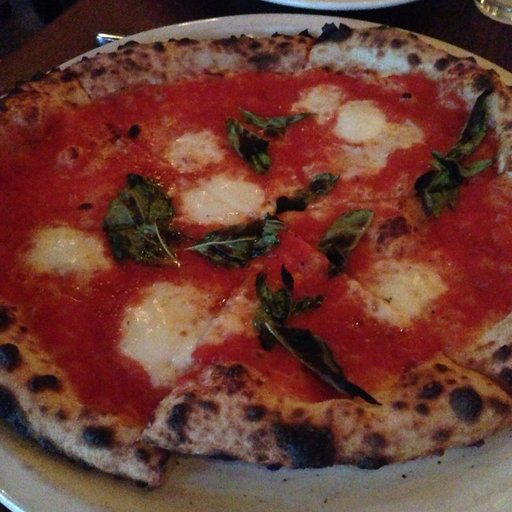

In [10]:
import random
from PIL import Image

# random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)
print(random_image_path)

image_class = random_image_path.parent.stem
print(image_class)

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img 



In [11]:
# 20:29:17 

In [12]:
# Visualise an image with matplotlib
image_path

PosixPath('data/pizza_steak_sushi')

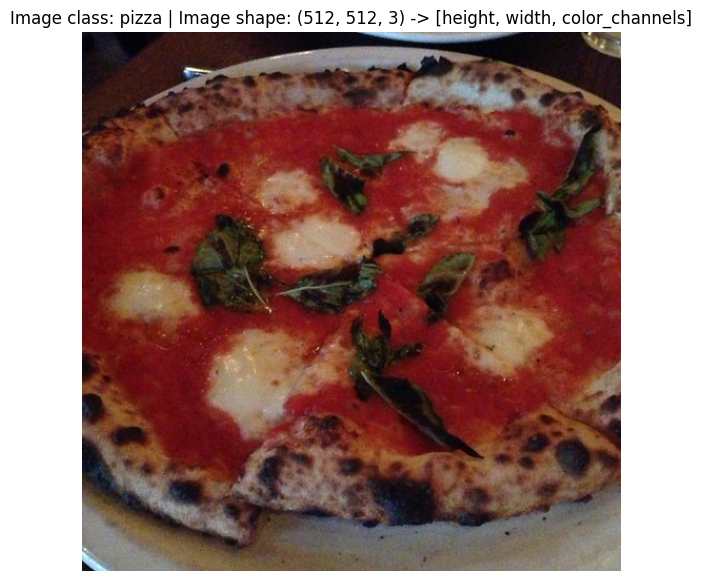

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);


In [14]:
img_as_array

array([[[ 27,  19,  30],
        [ 23,  15,  26],
        [ 20,  12,  23],
        ...,
        [123, 116,  87],
        [125, 119,  87],
        [131, 125,  93]],

       [[ 23,  15,  26],
        [ 24,  16,  27],
        [ 25,  17,  28],
        ...,
        [127, 116,  86],
        [126, 115,  83],
        [135, 124,  92]],

       [[ 21,  13,  24],
        [ 23,  15,  26],
        [ 25,  17,  28],
        ...,
        [132, 117,  84],
        [128, 114,  79],
        [129, 115,  80]],

       ...,

       [[ 29,  20,  21],
        [ 32,  23,  26],
        [ 26,  17,  22],
        ...,
        [148, 150, 137],
        [146, 150, 135],
        [152, 156, 141]],

       [[ 26,  21,  18],
        [ 29,  24,  21],
        [ 27,  21,  21],
        ...,
        [148, 150, 136],
        [146, 150, 135],
        [151, 155, 140]],

       [[ 32,  29,  24],
        [ 28,  25,  20],
        [ 21,  17,  14],
        ...,
        [149, 151, 137],
        [145, 149, 134],
        [148, 152, 135]]

In [15]:
# Transforming data

In [16]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

data_transform = transforms.Compose([
    # Resize images
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly (data augumentation)
    transforms.RandomHorizontalFlip(p=.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [17]:
data_transform(img).dtype

torch.float32

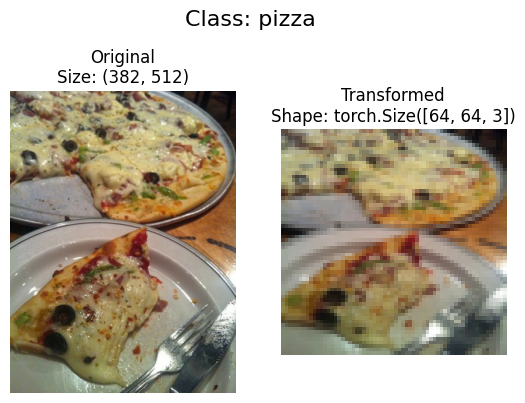

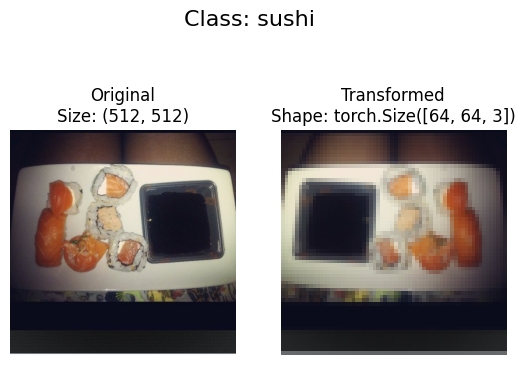

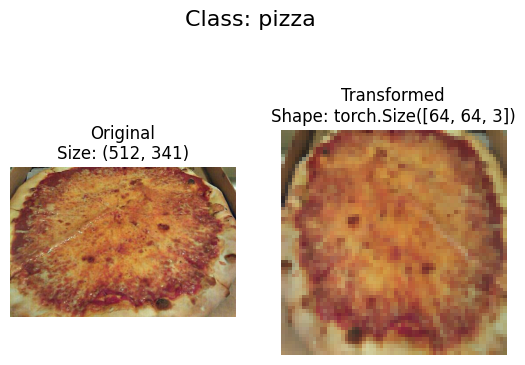

In [18]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
  """Selects random images from a path of images then and load/transforms
      them then plots the original vs transformed version"""
  if seed:
    random.seed(seed)

  random_image_paths = random.sample(image_paths, k=n)

  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)


      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # we will need to change shape (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)


plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        )




In [19]:
# 21:00:32

In [20]:
# Option 1: Loading image data using 'ImageFolder'

In [21]:
from torchvision import datasets


train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [22]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [23]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [24]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [25]:
# Check the lenght of our dataset
len(train_data), len(test_data)

(225, 75)

In [26]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [27]:
img, label = train_data[0][0], train_data[0][1]
type(label)

int

In [28]:
class_names[label]

'pizza'

torch.Size([64, 64, 3])


Text(0.5, 1.0, 'pizza')

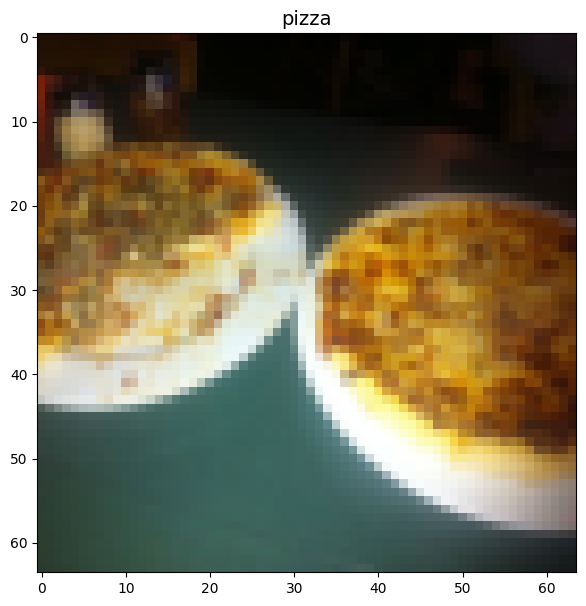

In [29]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)


# Print different shapes
print(img_permute.shape)

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.title(class_names[label], fontsize=14)

In [30]:
# Turn loaded images into DataLoader's

In [31]:
from torch.utils.data import DataLoader

BATCH_SIZE = 1

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                             shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader                             

(<torch.utils.data.dataloader.DataLoader at 0x7f9018e17130>,
 <torch.utils.data.dataloader.DataLoader at 0x7f9018e15090>)

In [32]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [33]:
len(train_data), len(test_data)

(225, 75)

In [34]:
img, label = next(iter(train_dataloader))

#Batch size will now be 1
print(f"Img shape: {img.shape} -> [batch_size, color_channels, height, width]")

Img shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]


In [35]:
# 21:25:19

In [36]:
## Option 2: Loading Image Data with a Custom `Dataset`

import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List


In [37]:
# Instance of torchvision.datasets.ImageFolder()

train_data.classes, train_data.class_to_idx


(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [38]:
# Creating a helper function to get class names

target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [39]:
list(os.scandir(target_directory))

[<DirEntry 'sushi'>, <DirEntry 'pizza'>, <DirEntry 'steak'>]

In [40]:
# 21:37:35 

In [41]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory."""
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Could't find any classes in {directory}... please check file structure.")

  # 3. Create a dictionary of index labels 
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [42]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

##Subclass torch.utils.data.Dataset

In [43]:
from torch.utils.data import Dataset


class ImageFolderCustom(Dataset):
  def __init__(self, targ_dir: str, transform=None):

    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    self.transform = transform
    self.classes, self.class_to_idx = find_classes(targ_dir)

  def load_image(self, index: int) -> Image.Image:
    "Opens and image via path and returns it."
    image_path = self.paths[index]
    return Image.open(image_path)

  # overwrite __len__()
  def __len__(self) -> int:
    "Return the total number of samples"
    return len(self.paths)

  # Overwrite __getitem__()
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)."
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx  # return data, label (X, y)
    else:
      return img, class_idx  # return untransformed image and label



In [44]:
# Create a transform
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [45]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)
                                      

In [46]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7f9018e41e70>,
 <__main__.ImageFolderCustom at 0x7f9018e43af0>)

In [47]:
len(train_data), len(train_data_custom)

(225, 225)

In [48]:
len(test_data), len(test_data_custom)

(75, 75)

In [49]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [50]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [51]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustom Data
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


#Create a function to display random images

In [52]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

  if seed:
    random.seed(seed)

  random_samples_idx = random.sample(range(len(dataset)), k=n)

  plt.figure(figsize=(16, 8))

  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    targ_image_adjust = targ_image.permute(1, 2, 0)  # [color_channels, height, width] -> [height, width, color_channels]

    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)
 

In [53]:
random.sample(range(len(train_data_custom)), k=10)

[169, 134, 72, 106, 189, 139, 209, 213, 97, 101]

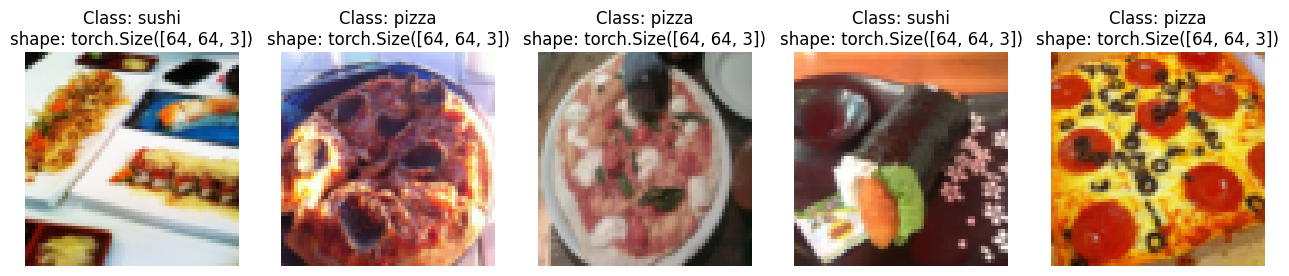

In [54]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data, n=5, classes=class_names, seed=42)

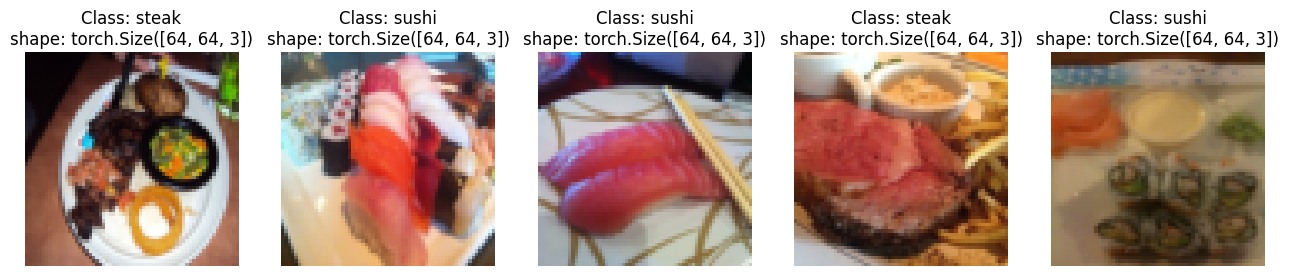

In [55]:
# Display random images from the ImageFolderCustom Dataset 
display_random_images(train_data_custom,
                      n=5,
                      classes=class_names,
                      seed=42)

In [56]:
# Turn customloaded images into DataLoader

In [57]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f9018a074c0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f9018a07850>)

In [58]:
# 22:22:56 

In [59]:
# Get image and label custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

# Data augmentation

In [60]:
from torchvision import transforms

train_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                      transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                      transforms.ToTensor()
])

test_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor()
])

image_path

PosixPath('data/pizza_steak_sushi')

In [61]:
# Get all the paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/sushi/3837522.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2190404.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1987407.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2521706.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2394442.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/3177743.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2715127.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1172255.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/3196729.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/479711.jpg')]

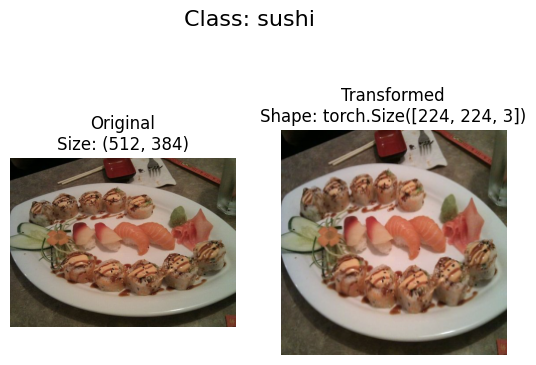

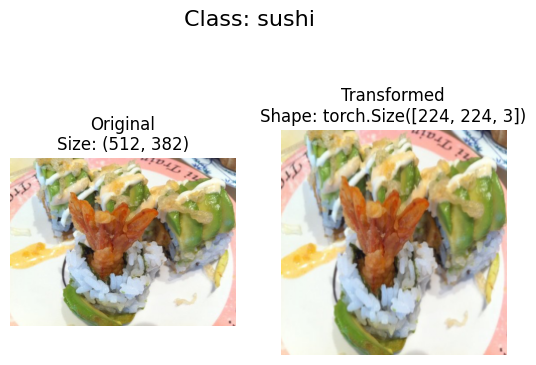

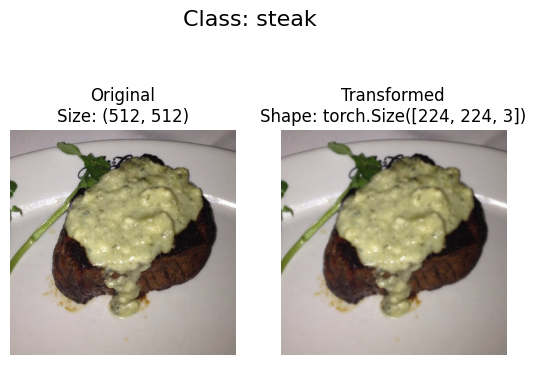

In [62]:
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform, 
    n=3,
    seed=None
)

#Model 0: Tiny VGG without data augumentation

In [63]:
# Create simple transform

simple_transform = transforms.Compose([transforms.Resize(size=(64, 64)),
                                      transforms.ToTensor()])

In [64]:
# Load and transform data
from torchvision import datasets

train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# Load data via dataloader / Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoader's
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS,)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS,)

In [65]:
# The Model!


class TinyVGG(nn.Module):
  def __init__(self, in_shape, out_shape, hidden_units) -> None:
    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels=in_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    self.block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=out_shape))

  def forward(self, x: torch.Tensor):
    x = self.block_1(x)
    # print(x.shape)
    x = self.block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x
    # return self.classifier(self.block_2(self.block_1(x)))  # benefits from operator fusion


torch.manual_seed(42)
model_0 = TinyVGG(in_shape=3,
                  out_shape=len(class_names),
                  hidden_units=10).to(device)

model_0

TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [66]:
# Try a forward pass on a single image batch (to test model)
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape


(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [67]:
model_0(image_batch.to(device))

tensor([[ 2.0789e-02, -1.9351e-03,  9.5317e-03],
        [ 1.8427e-02,  2.4670e-03,  6.6757e-03],
        [ 1.7699e-02,  1.0262e-03,  9.4657e-03],
        [ 2.4441e-02, -3.3526e-03,  9.6011e-03],
        [ 1.9930e-02,  6.6316e-04,  1.0779e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0999e-02,  1.2869e-04,  1.2473e-02],
        [ 2.1577e-02, -1.9507e-03,  9.6941e-03],
        [ 2.4504e-02, -4.7745e-03,  8.5280e-03],
        [ 2.0252e-02, -4.7292e-04,  1.0908e-02],
        [ 2.2215e-02, -4.1837e-04,  9.8123e-03],
        [ 2.2313e-02, -2.1622e-03,  9.4456e-03],
        [ 2.1841e-02, -3.7132e-03,  8.3783e-03],
        [ 2.2863e-02, -1.7723e-03,  1.0287e-02],
        [ 2.1647e-02, -4.4139e-03,  9.5021e-03],
        [ 2.2096e-02, -4.1426e-03,  9.3853e-03],
        [ 2.1209e-02, -4.4218e-03,  1.1475e-02],
        [ 2.1711e-02, -2.7656e-03,  8.5006e-03],
        [ 1.9951e-02,  2.8272e-05,  8.4380e-03],
        [ 1.8298e-02,  1.6306e-03,  8.5499e-03],
        [ 2.0768e-02

In [68]:
# 23:05:23 

Use of torchinfo

In [69]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary

summary(model_0, input_size=[1, 3, 64, 64])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.10/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.10/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [70]:
# 23:17:45 

In [71]:
# from helper_functions import accuracy

In [72]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.01)

In [73]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  
  model.train()
  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item() 

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item() / len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc


In [74]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):

  model.eval()
  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for batch, (X_test, y_test) in enumerate(dataloader):
      X_test, y_test = X_test.to(device), y_test.to(device)

      test_logits = model(X_test)

      loss = loss_fn(test_logits, y_test)
      test_loss += loss.item()

      test_pred_labels = test_logits.argmax(dim=1)
      test_acc += ((test_pred_labels==y_test).sum().item() / len(test_pred_labels))



  # Adjust metrics to get average
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)

  return test_loss, test_acc


In [75]:
# 23:30:49

In [76]:
# Train
torch.manual_seed(42)

from timeit import default_timer as timer


def my_train(train_step, test_step, epochs):
  train_time_start_on_gpu = timer()

  for epoch in range(epochs):
    print(f'Epoch: {epoch}')
    train_step(model_0,
              train_dataloader_simple,
              loss_fn,
              optimizer,
              device)
    
    test_step(model_0,
              test_dataloader_simple,
              loss_fn,
              device)
    
  train_time_end_on_gpu = timer()

  # total_train_time_model_0 = print_train_time(start=train_time_start_on_gpu,
  #                                             end=train_time_end_on_gpu,
  #                                             device=device)


In [77]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module=nn.CrossEntropyLoss(),
          epochs=5,
          device=device):
  
  results = {'train_loss': [],
             'train_acc': [],
             'test_loss': [],
             'test_acc': [],
             }

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)
    

    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | "
          f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")
    
    # Update
    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)

  return results


In [78]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

model_0 = TinyVGG(in_shape=3,
                  hidden_units=10,
                  out_shape=len(train_data.classes)).to(device)
                
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

from timeit import default_timer as timer

start_time = timer()

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

end_time = timer()
print(f'Total training time: {end_time - start_time:.3f} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1063 | Train acc: 0.3047 | Test loss: 1.0983 | Test acc: 0.3116
Epoch: 1 | Train loss: 1.0995 | Train acc: 0.3320 | Test loss: 1.0699 | Test acc: 0.5417
Epoch: 2 | Train loss: 1.0863 | Train acc: 0.4922 | Test loss: 1.0800 | Test acc: 0.5227
Epoch: 3 | Train loss: 1.0826 | Train acc: 0.4102 | Test loss: 1.0599 | Test acc: 0.5729
Epoch: 4 | Train loss: 1.0630 | Train acc: 0.4141 | Test loss: 1.0609 | Test acc: 0.5540
Total training time: 8.477 seconds


In [79]:
model_0_results

{'train_loss': [1.1063424050807953,
  1.0994839370250702,
  1.086288720369339,
  1.0826255679130554,
  1.0630027651786804],
 'train_acc': [0.3046875, 0.33203125, 0.4921875, 0.41015625, 0.4140625],
 'test_loss': [1.0983142455418904,
  1.0698524316151936,
  1.0800265471140544,
  1.059857964515686,
  1.0609312454859416],
 'test_acc': [0.31155303030303033,
  0.5416666666666666,
  0.5227272727272728,
  0.5729166666666666,
  0.5539772727272728]}

In [80]:
# Loss curves

model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

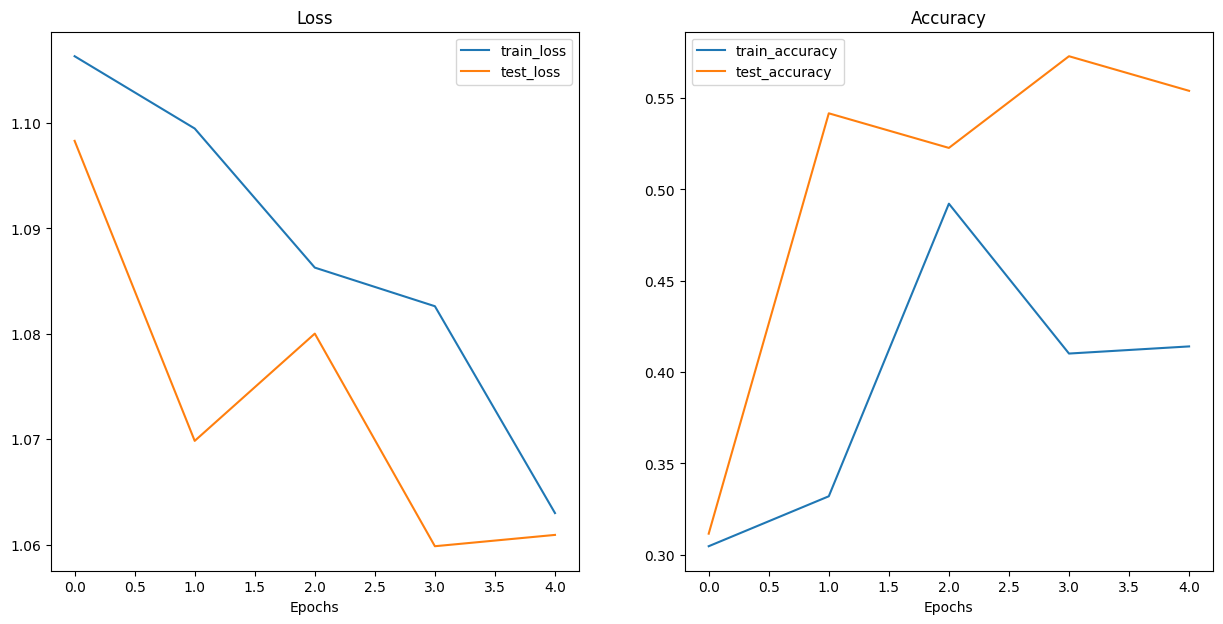

In [81]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of a results dictionary"""
  loss = results['train_loss']
  test_loss = results['test_loss']

  accuracy = results['train_acc']
  test_accuracy = results['test_acc']

  epochs = range(len(results['train_loss']))

  plt.figure(figsize=(15, 7))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label='train_loss')
  plt.plot(epochs, test_loss, label='test_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label='train_accuracy')
  plt.plot(epochs, test_accuracy, label='test_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();


plot_loss_curves(model_0_results)

In [82]:
# 1:00:00:02 

#TinyVGG with data augumentation

In [83]:
from torchvision import transforms

train_transform_trivial = transforms.Compose([transforms.Resize(size=(64, 64)),
                                             transforms.TrivialAugmentWide(num_magnitude_bins=5),
                                             transforms.ToTensor(),
                                             ])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
])

In [84]:
# Datasets and DataLoaders

In [85]:
from torchvision import datasets

train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)


train_data_simple = datasets.ImageFolder(root=test_dir,
                                         transform=test_transform_simple)




In [86]:
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augumented = DataLoader(dataset=train_data_augmented,
                                         batch_size=BATCH_SIZE,
                                         shuffle=False,
                                         num_workers=NUM_WORKERS)

test_dataloader_augumented = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)


In [87]:
# Model!

class TinyVGGv2(nn.Module):
  def __init__(self, in_shape, hidden_units, out_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(
            in_channels=in_shape,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2),
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2),
    )

    # self.conv_block_3 = nn.Sequential(
    #     nn.Conv2d(
    #         in_channels=hidden_units,
    #         out_channels=hidden_units,
    #         kernel_size=3,
    #         stride=1),
    #     nn.ReLU(),
    #     nn.Conv2d(
    #         in_channels=hidden_units,
    #         out_channels=hidden_units,
    #         kernel_size=3,
    #         stride=1),
    #     nn.ReLU(),
    #     nn.MaxPool2d(kernel_size=2,
    #                  stride=2),
    # )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13, # ?
                  out_features=out_shape)
    )

  def forward(self, x: torch.Tensor) -> None:
    # x = self.conv_block_1(x)
    # print(x.shape)
    # x = self.conv_block_2(x)
    # print(x.shape)
    # # x = self.conv_block_3(x)
    # # print(x.shape)
    # x = self.classifier(x)
    # print(x.shape)
    # return x

    return self.classifier(self.conv_block_2(self.conv_block_1(x)))


model_1 = TinyVGGv2(in_shape=3,
                    hidden_units=10,
                    out_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGGv2(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [88]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary

summary(model_1, input_size=[1, 3, 64, 64])

torch.Size([1, 10, 30, 30])
torch.Size([1, 10, 13, 13])
torch.Size([1, 3])


/usr/local/lib/python3.10/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.10/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGGv2                                [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [89]:
# Try a forward pass on a single image batch (to test model)
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

model_1(image_batch.to(device))

torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])


tensor([[ 2.4292e-02, -4.2148e-03,  9.1331e-03],
        [ 2.0496e-02, -7.8159e-04,  8.4746e-03],
        [ 2.0252e-02, -4.7292e-04,  1.0908e-02],
        [ 2.2778e-02, -2.7411e-03,  1.1190e-02],
        [ 1.8335e-02,  1.8651e-04,  6.0225e-03],
        [ 2.1921e-02, -1.7709e-03,  8.1947e-03],
        [ 2.2924e-02, -1.4935e-03,  1.0275e-02],
        [ 2.0078e-02,  4.5732e-04,  1.0555e-02],
        [ 2.0918e-02,  1.2968e-04,  8.8678e-03],
        [ 1.9509e-02,  7.8303e-04,  8.2038e-03],
        [ 1.9475e-02, -2.1625e-03,  9.9487e-03],
        [ 1.9281e-02, -5.5920e-03,  1.2914e-02],
        [ 2.0930e-02, -4.5746e-03,  8.4647e-03],
        [ 2.2065e-02, -4.6434e-03,  1.2666e-02],
        [ 2.0798e-02,  1.9524e-04,  9.1937e-03],
        [ 2.1513e-02, -6.1432e-04,  7.3849e-03],
        [ 2.4599e-02, -3.2342e-03,  8.6987e-03],
        [ 1.9834e-02, -3.9071e-03,  9.8740e-03],
        [ 2.1272e-02, -1.6094e-03,  9.5620e-03],
        [ 1.8849e-02, -4.1510e-04,  8.4803e-03],
        [ 2.1703e-02

In [90]:
!pwd

/content


In [91]:
from timeit import default_timer as timer

torch.manual_seed(42)
torch.cuda.manual_seed(42)

optimizer = torch.optim.Adam(model_1.parameters(),
                             lr=0.0001)

NUM_EPOCHS = 5

start_time = timer()

model_1_results  = train(model_1,
                         train_dataloader_augumented,
                         test_dataloader_simple,
                         loss_fn=nn.CrossEntropyLoss(),
                         optimizer=optimizer,
                         epochs=NUM_EPOCHS,
                         device=device)

end_time = timer()
print(f"Training time took: {end_time - start_time} seconds.")

  0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([1, 10, 30, 30])
torch.Size([1, 10, 13, 13])
torch.Size([1, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])
torch.Size([11, 10, 30, 30])
torch.Size([11, 10, 13, 13])
torch.Size([11, 3])
Epoch: 0 | Train loss: 1.1084 | Train acc: 0.3047 | Test loss: 1.1042 | Test acc: 0.2604
torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13]

In [92]:
# 1:00:26:00

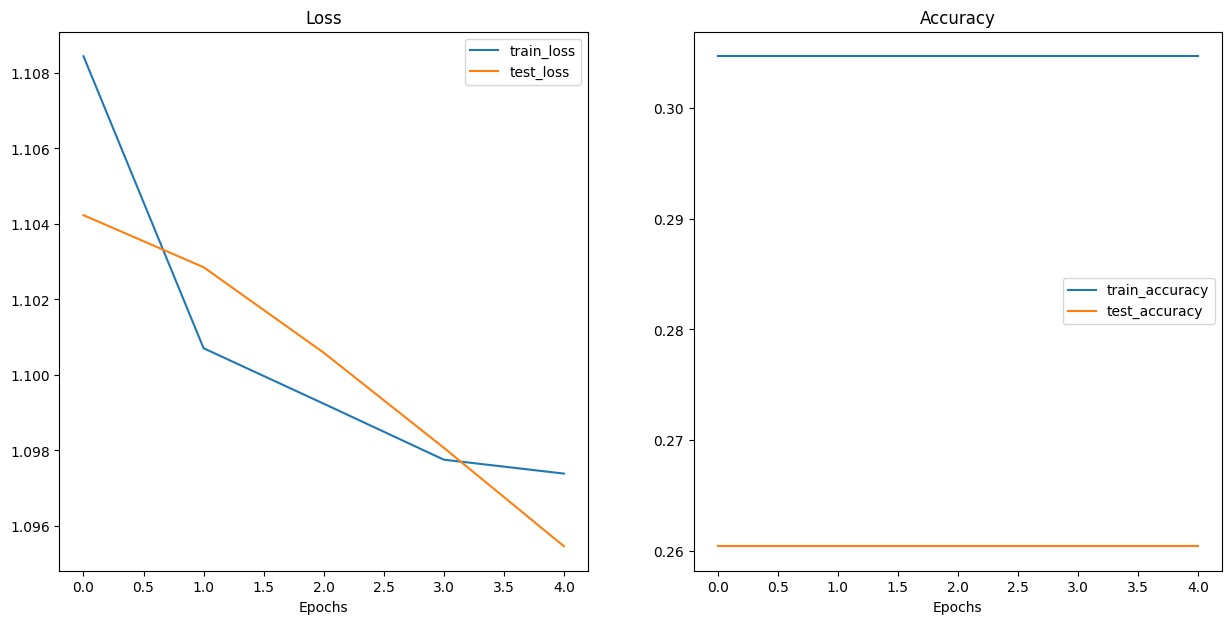

In [93]:
plot_loss_curves(model_1_results)

In [94]:
# Compare model results

# Important to compare with baseline model

In [95]:
import pandas as pd

model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106342,0.304688,1.098314,0.311553
1,1.099484,0.332031,1.069852,0.541667
2,1.086289,0.492188,1.080027,0.522727
3,1.082626,0.410156,1.059858,0.572917
4,1.063003,0.414062,1.060931,0.553977


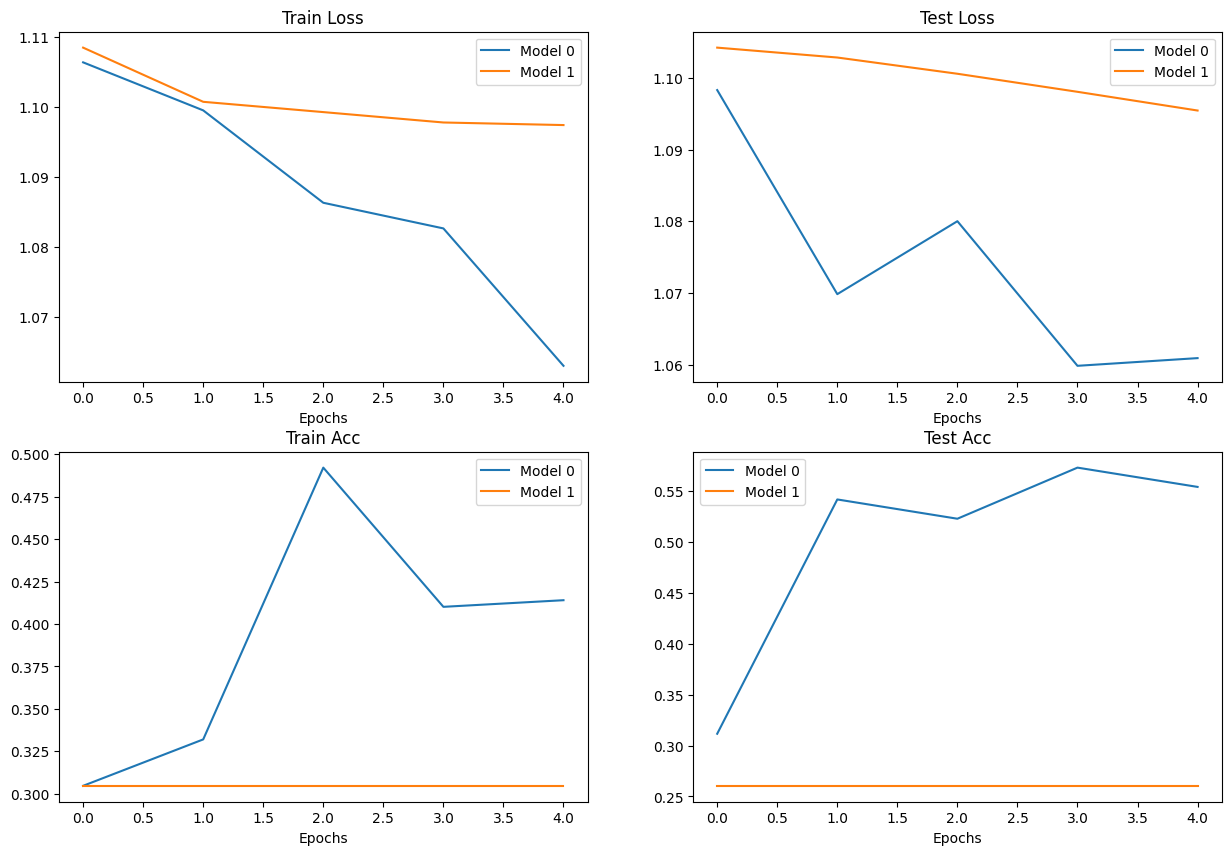

In [96]:
plt.figure(figsize=(15, 10))

epochs = range(len(model_0_df))

# Train loss plot
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df['train_loss'], label='Model 0')
plt.plot(epochs, model_1_df['train_loss'], label='Model 1')
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.legend();

# Test loss plot
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df['test_loss'], label='Model 0')
plt.plot(epochs, model_1_df['test_loss'], label='Model 1')
plt.title('Test Loss')
plt.xlabel('Epochs')
plt.legend();

# Train Acc plot
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df['train_acc'], label='Model 0')
plt.plot(epochs, model_1_df['train_acc'], label='Model 1')
plt.title('Train Acc')
plt.xlabel('Epochs')
plt.legend();

# Test loss plot
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df['test_acc'], label='Model 0')
plt.plot(epochs, model_1_df['test_acc'], label='Model 1')
plt.title('Test Acc')
plt.xlabel('Epochs')
plt.legend();

In [97]:
# Making a prediction on a custom image

# download custom image
import requests

custom_image_path = data_path / '04-pizza-dad.jpeg'

# Download the image
if not custom_image_path.is_file():
  with open(custom_image_path, 'wb') as f:
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg')
    print(f'Downloading {custom_image_path}..')
    f.write(request.content)
else:
  print(f'{custom_image_path} already exists, skipping download')    

In [98]:
# Loading in a  custom image with PyTorch

In [99]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
print(f'Custom image tensor:\n {custom_image_uint8}')
print(f'Custom image shape: {custom_image_uint8.shape}')
print(f'Custom image datatype: {custom_image_uint8.dtype}')


Custom image tensor:
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 4032, 3024])
Custom image data

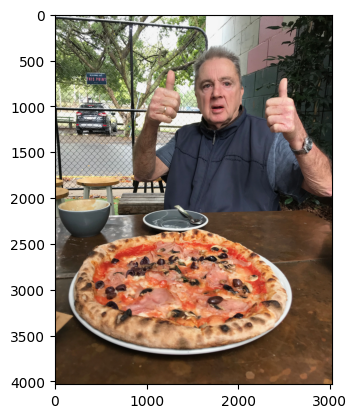

In [100]:
plt.imshow(custom_image_uint8.permute(1, 2, 0));

In [101]:
# Making a prediction on a custom image with a trained PyTorch model

# # Image in uint8 format
# model_1.eval()
# with torch.inference_mode():
#   model_1(custom_image_uint8.to(device))

In [102]:
# Load in the custom image and convert to torch.float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.
custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

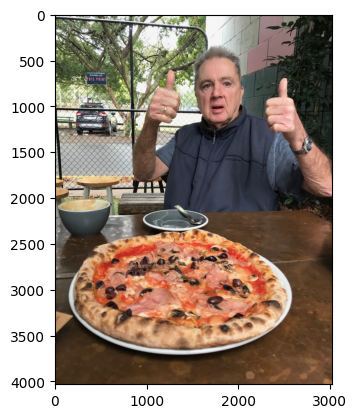

In [103]:
plt.imshow(custom_image.permute(1, 2, 0));

In [104]:
custom_image.shape

torch.Size([3, 4032, 3024])

In [105]:
# model_1.eval()
# with torch.inference_mode():
#   model_1(custom_image.to(device))

In [106]:
# Create transform pipeline to resize image
from torchvision import transforms

custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64))
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out the shapes
print(f'Original shape: {custom_image.shape}')
print(f'Transformed shape: {custom_image_transformed.shape}')


Original shape: torch.Size([3, 4032, 3024])
Transformed shape: torch.Size([3, 64, 64])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


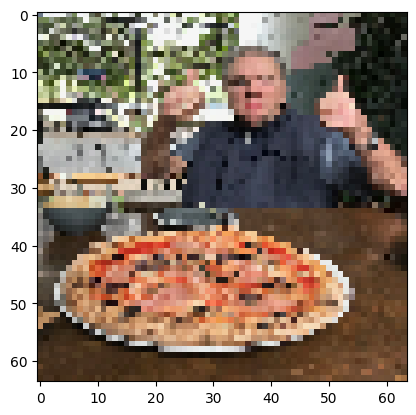

In [107]:
plt.imshow(custom_image_transformed.permute(1, 2, 0));

In [108]:
# # This will error - no batch size
# model_1.eval()
# with torch.inference_mode():
#   custom_image_pred = model_1(custom_image_transformed.to(device))


In [109]:
custom_image_transformed.shape, custom_image_transformed.unsqueeze(0).shape

(torch.Size([3, 64, 64]), torch.Size([1, 3, 64, 64]))

In [110]:
# Added a batch size
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))
custom_image_pred

torch.Size([1, 10, 30, 30])
torch.Size([1, 10, 13, 13])
torch.Size([1, 3])


tensor([[ 0.0329, -0.0306,  0.0002]], device='cuda:0')

In [111]:
class_names

['pizza', 'steak', 'sushi']

In [112]:
# Convert logits -> prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.3441, 0.3229, 0.3330]], device='cuda:0')

In [113]:
# Convert prediction probabilities -> prediction labels
custom_image_label = torch.argmax(custom_image_pred_probs, dim=1)
custom_image_label

tensor([0], device='cuda:0')

In [114]:
class_names[custom_image_label]

'pizza'

In [115]:
# Putting custom image prediction together: building a function 

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device=device):
  
  """Makes a prediction on a target image with a trained model and plots the image and prediction."""
  # Load in image
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # Divide the image pixel values by 255 to get them between [0, 1]
  target_image = target_image / 255.

  # Transform if necessary
  if transform:
    target_image = transform(target_image)

  # Make sure the model is on the target device
  model.to(device)

  # Turn on eval/inference mode and make a prediction
  model.eval()
  with torch.inference_mode():
    # Add an extra dimension to the image (this is the batch dimension, e.g. our model will predict on
    # batches of 1x image)
    target_image = target_image.unsqueeze(0)

    # Make a prediction on the image with an extra dimension
    target_image_pred = model(target_image.to(device)) 

  # Convert logits -> prediction probabilities
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # Convert prediction probabilities -> prediction labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # Plot the image alongside the prediction and prediction probability
  plt.imshow(target_image.squeeze().permute(1, 2, 0)) # remove batch dimension and rearange ahape to be HWC
  if class_names:
    title = f'Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}'
  else:
    title = f'Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu:.3f}'
  plt.title(title)
  plt.axis(False)


torch.Size([1, 10, 30, 30])
torch.Size([1, 10, 13, 13])
torch.Size([1, 3])


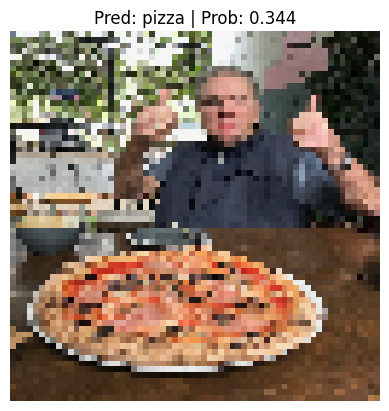

In [116]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)